# Filter

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

from tqdm import tqdm

import importlib
import sys
import os 
sys.path.insert(0, os.path.abspath(os.path.join('../src/')))
import simulate_multi_data
importlib.reload(simulate_multi_data)

<module 'simulate_multi_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_multi_data.py'>

In [ ]:
true_params = {
    'rt_m': [1.3, 2.5, 4.7], 
    'midpoint': [190.,300],
    'k': [0.1, 0.8],
    'n_t': 500,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_multi_data.simulate_multi_data(**true_params, add_noise=True, noise_param=1/50)

data.compute_data_distribution()

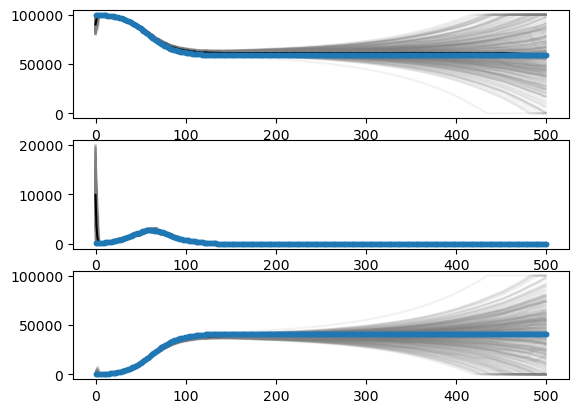

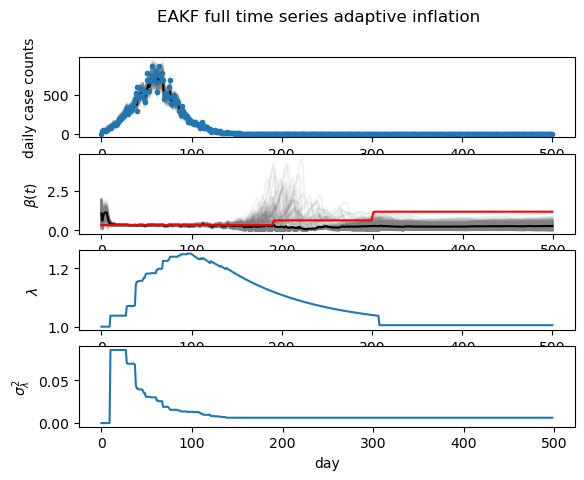

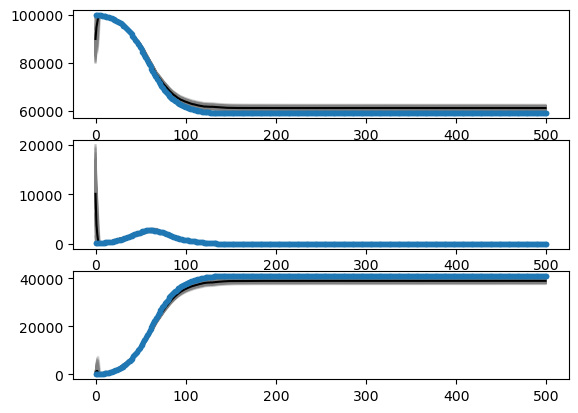

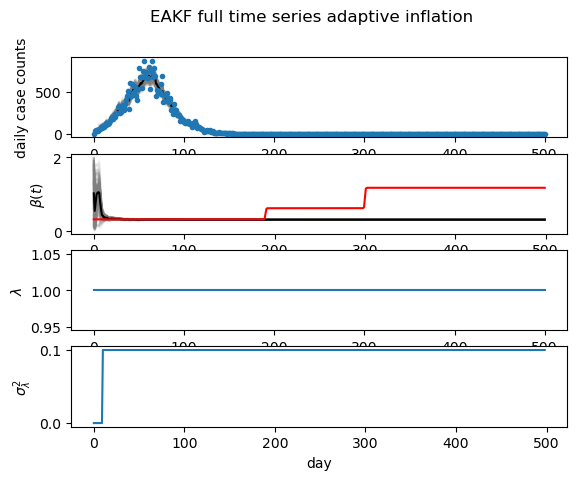

In [ ]:
import model_da
importlib.reload(model_da)

model = model_da.SIR_model(data)

import eakf
importlib.reload(eakf)

kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)

from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}

kf.filter(prior)
kf.plot_posterior()

kf_no = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf_no.filter(prior, inf_method="none")
kf_no.plot_posterior()

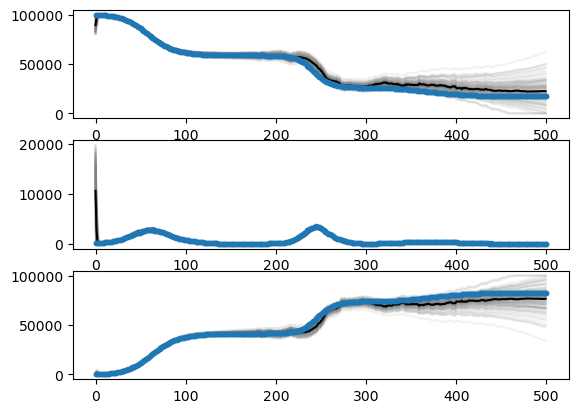

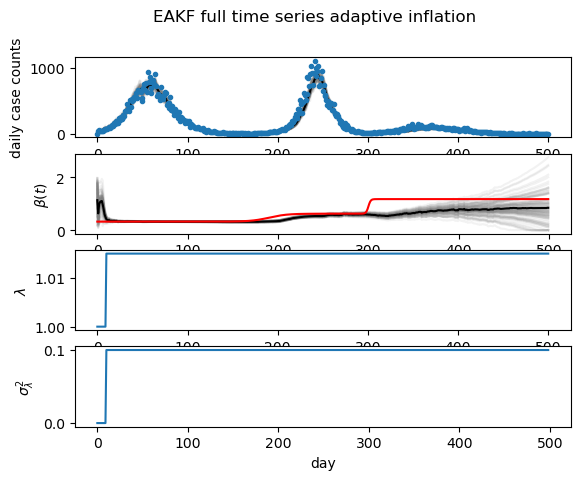

In [28]:
kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=100)
kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.015)
kf_fixed.plot_posterior()

# Make GIF

In [47]:
from matplotlib.pyplot import plot, figure, clf
from numpy import linspace
from tempfile import mkstemp, mkdtemp
from imageio import imread, mimsave

In [48]:
beta = np.array([θ.beta for θ in kf.θ_list])
beta_no = np.array([θ.beta for θ in kf_no.θ_list])
beta_fixed = np.array([θ.beta for θ in kf_fixed.θ_list])

In [49]:
# # tempdir = mkdtemp()

# pngs = []

# for i, frame in enumerate(range(0, beta_no.shape[0], 10)):
    

#     fig, ax = plt.subplots()
#     ax.plot(np.arange(0, frame), beta_no[0:frame,:], color='blue', alpha=0.05)
#     ax.plot(np.arange(0, frame), np.median(beta_no, axis=1)[0:frame], color="blue", label=r"No inflation")
#     # ax.plot(np.arange(0, frame), beta[0:frame,:], color='purple', alpha=0.1)
#     ax.plot(kf_no.data.beta, color="red", label=r"Synthetic truth")
#     ax.set_xlabel("day", fontsize=12)
#     ax.set_ylabel(r"$\beta(t)$", fontsize=12)
#     ax.legend()
#     ax.grid()
    
#     filename = f'div-{i}.png'
    
#     fig.savefig(filename)
#     clf() # clear figure
#     pngs.append(filename)

# fig, ax = plt.subplots()
# ax.plot(beta_no, color='#4682b4', alpha=0.05)
# ax.plot(np.median(beta_no, axis=1), color="#4682b4", label=r"EAKF with no inflation")
# # ax.plot(np.arange(0, frame), beta[0:frame,:], color='purple', alpha=0.1)
# ax.plot(kf_no.data.beta, color="red", label=r"Synthetic truth")
# ax.set_xlabel("day", fontsize=12)
# ax.set_ylabel(r"$\beta(t)$", fontsize=12)
# ax.legend()
# ax.grid()

# filename = f'div-{i+1}.png'

# fig.savefig(filename)
# clf() # clear figure
# pngs.append(filename)

# images = []
# for png in pngs:
#     img = imread(png)
#     images.append(img)
# mimsave('div.gif', images)

In [50]:
confidence_level = 95
ci = np.percentile([θ.beta for θ in kf.θ_list], [100 - confidence_level, confidence_level], axis=1)

confidence_level = 95
ci_no = np.percentile([θ.beta for θ in kf_no.θ_list], [100 - confidence_level, confidence_level], axis=1)

confidence_level = 95
ci_fixed = np.percentile([θ.beta for θ in kf_fixed.θ_list], [100 - confidence_level, confidence_level], axis=1)

In [51]:
np.max(ci)

1.9201681193952929

In [53]:

pngs = []

for i, frame in enumerate(range(0, beta_no.shape[0], 10)):

    fig, ax = plt.subplots()
    
    # ax.plot(np.arange(0, frame), beta_no[0:frame,:], color='#4682b4', alpha=0.05)
    ax.fill_between(np.arange(0, frame), ci_no[0,:frame], ci_no[1,:frame], color='#4682b4', alpha=0.3)
    ax.plot(np.arange(0, frame), np.median(beta_no, axis=1)[0:frame], color="#4682b4", label=r"No inflation (95% CI)")
    
    # ax.plot(np.arange(0, frame), beta_fixed[0:frame,:], color='#03522D', alpha=0.05)
    ax.fill_between(np.arange(0, frame), ci_fixed[0,:frame], ci_fixed[1,:frame], color='#ff7f00', alpha=0.3)
    ax.plot(np.arange(0, frame), np.median(beta_fixed, axis=1)[0:frame], color="#ff7f00", label=r"Fixed inflation (95% CI)")
    
    # ax.plot(np.arange(0, frame), beta[0:frame,:], color='#03522D', alpha=0.05)
    ax.fill_between(np.arange(0, frame), ci[0,:frame]*1.05, ci[1,:frame]*.95, color='#03522D', alpha=0.3)
    ax.plot(np.arange(0, frame), np.median(beta, axis=1)[0:frame], color="#03522D", label=r"Adaptive inflation (95% CI)")
    
    
    ax.plot(kf_no.data.beta, color="#B22222", label=r"Synthetic truth")
    ax.set_xlabel("day", fontsize=12)
    ax.set_ylabel(r"$\beta(t)$", fontsize=12)
    ax.legend()
    ax.grid()
    
    ax.set_ylim(0, 2.2)
    
    filename = f'all-{i}.png'
    
    fig.savefig(filename)
    clf() # clear figure
    pngs.append(filename)

fig, ax = plt.subplots()

# ax.plot(beta_no, color='#4682b4', alpha=0.05)
ax.fill_between(np.arange(0, 500), ci_no[0,:], ci_no[1,:], color='#4682b4', alpha=0.3)
ax.plot(np.median(beta_no, axis=1), color="#4682b4", label=r"No inflation (95% CI)")

# ax.plot(beta_fixed[0:frame,:], color='#03522D', alpha=0.05)
ax.fill_between(np.arange(0, 500), ci_fixed[0,:], ci_fixed[1,:], color='#ff7f00', alpha=0.3)
ax.plot(np.median(beta_fixed, axis=1), color="#ff7f00", label=r"Fixed inflation (95% CI)")

# ax.plot(beta, color='#03522D', alpha=0.05)
ax.fill_between(np.arange(0, 500), ci[0,:]*1.05, ci[1,:]*.95, color='#03522D', alpha=0.3)
ax.plot(np.median(beta, axis=1), color="#03522D", label=r"Adaptive inflation (95% CI)")


ax.plot(kf_no.data.beta, color="#B22222", label=r"Synthetic truth")
ax.set_xlabel("day", fontsize=12)
ax.set_ylabel(r"$\beta(t)$", fontsize=12)
ax.legend()
ax.grid()
ax.set_ylim(0, 2.2)

filename = f'all-{i+1}.png'

fig.savefig(filename)
clf() # clear figure
pngs.append(filename)

images = []
for png in pngs:
    img = imread(png)
    images.append(img)
mimsave('all.gif', images)

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_9585/3256691599.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_9585/3256691599.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(png)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>